# RFM Clustering Online Retail Data
In this series of notebooks, we'll be following along with Baris Karaman's excellent series of blog posts on TowardsDataScience. 

https://towardsdatascience.com/data-driven-growth-with-python-part-2-customer-segmentation-5c019d150444

We'll be working with a variety of datasets employing various DS concepts that are core to marketing. We're going to start with an exercise called "RFM clustering", an unsupervised learning technique that seeks to group customers based on recency, frequency, and monetary value.

The dataset we'll be leveraging is an **Online Retail Data Set**. It would be best to take a look at the dataset and perform some quck EDA before proceeding.

In [554]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings


#### Get A Sense for Retail Dataset

In [555]:
df = pd.read_csv('OnlineRetail.csv', engine='python')

In [556]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [557]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [558]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [559]:
len(df.StockCode.unique()), len(df.StockCode)

(4070, 541909)

In [560]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


Huge outliers for out numerical features of interest (Unit Price and Quantity). This is keeping with typical eComm data-- a huge amount of users with no purchases, and a small amount of users with exceptionally high purchases. 

Also interesting here are the negative sales. While some companies operate in this manner for returns, we'll exclude for now.

#### Drop Negative Sales

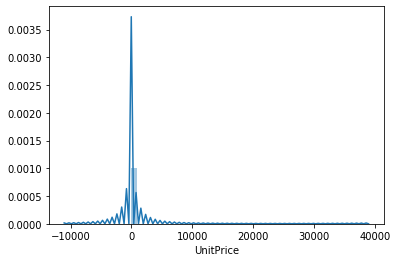

In [561]:
sns.distplot(df.UnitPrice);

In [562]:
df[df.UnitPrice < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,8/12/2011 14:51,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,8/12/2011 14:52,-11062.06,NaN,United Kingdom


In [563]:
df = df[df.UnitPrice > 0]

#### Country

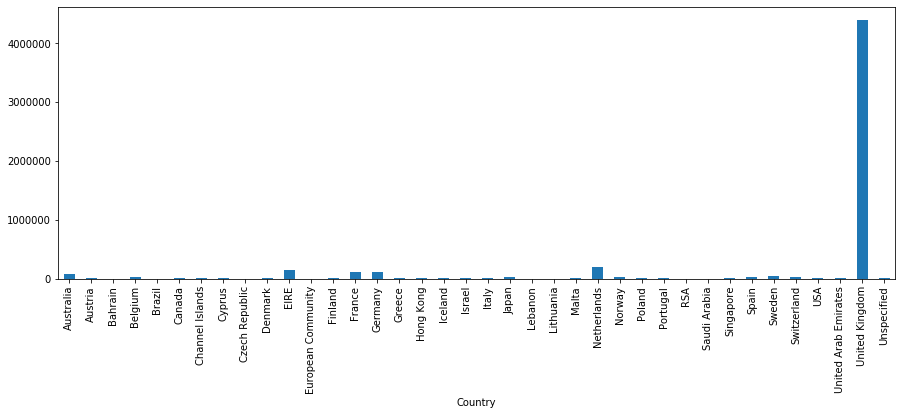

In [564]:
plt.figure(figsize=(15,5))
df.groupby('Country')['Quantity'].sum().plot(kind='bar');

In [565]:
df.Country.value_counts(normalize=True).head()

United Kingdom    0.913953
Germany           0.017599
France            0.015862
EIRE              0.015187
Spain             0.004694
Name: Country, dtype: float64

For our purposes, we'll isolate to the UK only because ~91% of our data is coming from this country.

In [566]:
df = df[df.Country=='United Kingdom']

#### Date

In [567]:
df.InvoiceDate = pd.to_datetime(df.InvoiceDate)

In [568]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [569]:
df.InvoiceDate.min(),df.InvoiceDate.max()

(Timestamp('2010-12-01 08:26:00'), Timestamp('2011-12-09 12:49:00'))

### Recency

In [570]:
#Start with our unique customer IDS
df_customers = pd.DataFrame(df.CustomerID.unique())
df_customers.columns = ['CustomerID']

#grab max purchase dates and calculate the recency of purchase relative to our most recent purchase
max_purch = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
max_purch.columns = ['CustomerID','MaxPurchaseDate']
max_purch['Recency'] = max_purch['MaxPurchaseDate'].max() - max_purch['MaxPurchaseDate']
max_purch['Recency'] = max_purch['Recency'].dt.days

#Merge back together
df_customers = pd.merge(df_customers, max_purch[['CustomerID','Recency']], on='CustomerID')

df_customers.head(3)


,CustomerID,Recency
0,17850.0,301
1,13047.0,31
2,13748.0,95


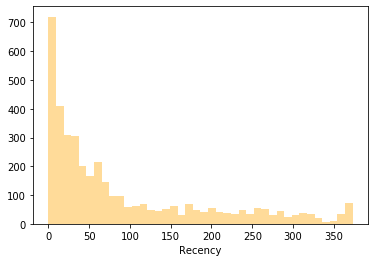

In [571]:
sns.distplot(df_customers.Recency, bins=40, kde=False, color='Orange');

In [572]:
df_customers.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,3949.0,15562.613320,1576.620800,12346.0,14209.0,15572.0,16914.0,18287.0
Recency,3949.0,90.798177,100.235397,0.0,16.0,49.0,142.0,373.0


Based on our above data, we see the same general distribution that we saw with our purchase counts (Poisson). We are heavily skewed toward recent purchases, with some amount of purchasers approaching a year of inactivty.

We'll now leverage K-means to determine how we should be clustering this dataset.

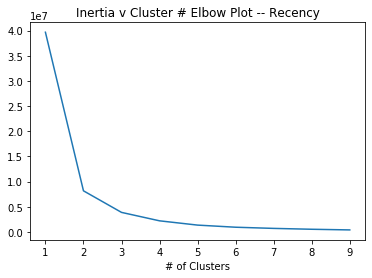

In [573]:
import warnings
warnings.filterwarnings('ignore')

inertia={}

df_rec = df_customers[['Recency']]

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_rec)
    df_rec["clusters"] = kmeans.labels_
    inertia[k] = kmeans.inertia_ 
    
    
plt.figure()
plt.plot(list(inertia.keys()), list(inertia.values()))
plt.title('Inertia v Cluster # Elbow Plot -- Recency')
plt.xlabel("# of Clusters")
plt.show()

We'll be moving ahead with 3 clusters, this is where we see the returns on inertia diminish.

In [574]:
km = KMeans(n_clusters = 3)
km.fit(df_rec)
df_customers['RecencyCluster'] = km.predict(df_rec)

We can take a look at how our features vary by our new clusters.

In [575]:
#Temp read back into our original dataframe to assess what our clusters look like.
pd.merge(df, df_customers.drop(columns=['Recency']), on='CustomerID', how='inner').groupby('RecencyCluster').describe()[['Quantity', 'UnitPrice']].T

RecencyCluster              0              1             2
Quantity  count  29602.000000  319175.000000  13077.000000
          mean      10.374434      11.204079      8.613214
          std       49.171558     207.468879    920.863916
          min    -1350.000000  -80995.000000 -74215.000000
          25%        2.000000       2.000000      1.000000
          50%        4.000000       4.000000      4.000000
          75%       12.000000      12.000000     10.000000
          max     4300.000000   80995.000000  74215.000000
UnitPrice count  29602.000000  319175.000000  13077.000000
          mean       4.988801       3.084786      3.518562
          std      228.872567      28.263920      8.169782
          min        0.001000       0.001000      0.080000
          25%        1.250000       1.250000      1.250000
          50%        1.950000       1.950000      2.100000
          75%        3.750000       3.750000      3.950000
          max    38970.000000    8142.750000    308.820000

In [576]:
df_customers.groupby('RecencyCluster').describe()['Recency']

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,732.0,154.517760,38.145893,93.0,120.0,154.0,186.0,224.0
1,2659.0,30.523129,25.210172,0.0,9.0,24.0,49.5,92.0
2,558.0,294.433692,45.277184,225.0,256.0,287.0,329.0,373.0


In [577]:
df_customers.RecencyCluster = df_customers.RecencyCluster.map({0:1, 1:2, 2:0})

In [578]:
df_customers.groupby('RecencyCluster').describe()['Recency']

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,558.0,294.433692,45.277184,225.0,256.0,287.0,329.0,373.0
1,732.0,154.517760,38.145893,93.0,120.0,154.0,186.0,224.0
2,2659.0,30.523129,25.210172,0.0,9.0,24.0,49.5,92.0


### Frequency

We'll take the same approach for frequency that we did with recency...

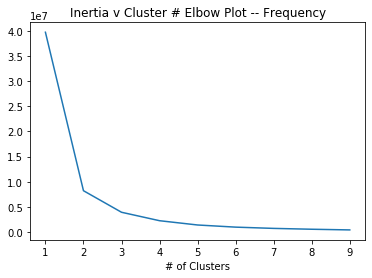

In [579]:
df_freq = df.groupby('CustomerID')['InvoiceDate'].count().reset_index()
df_freq.columns = ['CustomerID', 'Freq']

df_customers = pd.merge(df_customers, df_freq, how = 'inner', on='CustomerID')

df_freq_plot = df_customers[['Freq']]

inertia={}


for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_rec)
    df_freq["clusters"] = kmeans.labels_
    inertia[k] = kmeans.inertia_ 
    
plt.figure()
plt.plot(list(inertia.keys()), list(inertia.values()))
plt.title('Inertia v Cluster # Elbow Plot -- Frequency')
plt.xlabel("# of Clusters")
plt.show()

3 appears to be the best, similar to recency. let's procceed with the same process

In [580]:
km = KMeans(n_clusters = 3)
km.fit(df_freq)
df_customers['FreqCluster'] = km.predict(df_freq)

In [581]:
df_customers.groupby('FreqCluster').describe()['Freq']

,count,mean,std,min,25%,50%,75%,max
FreqCluster,,,,,,,,
0,1298.0,49.618644,156.170503,1.0,12.0,26.0,53.00,5128.0
1,1320.0,156.424242,328.315999,1.0,29.0,82.0,177.75,7983.0
2,1331.0,68.346356,85.443774,1.0,16.0,40.0,89.00,1128.0


In [582]:
df_customers.FreqCluster = df_customers.FreqCluster.map({0:0, 1:2, 2:1})

In [583]:
df_customers.groupby('FreqCluster').describe()['Freq']

,count,mean,std,min,25%,50%,75%,max
FreqCluster,,,,,,,,
0,1298.0,49.618644,156.170503,1.0,12.0,26.0,53.00,5128.0
1,1331.0,68.346356,85.443774,1.0,16.0,40.0,89.00,1128.0
2,1320.0,156.424242,328.315999,1.0,29.0,82.0,177.75,7983.0


### Monetary Value

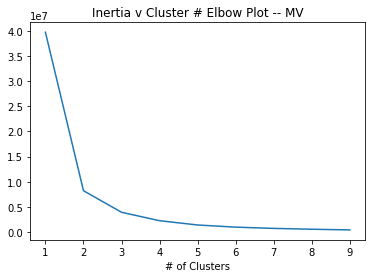

In [584]:
df_dollars = df.groupby('CustomerID')['UnitPrice'].sum().reset_index()
df_dollars.columns = ['CustomerID', 'UnitPrice']

df_customers = pd.merge(df_customers, df_dollars, how = 'inner', on='CustomerID')

df_dollar_plot = df_customers[['UnitPrice']]

inertia={}


for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_rec)
    df_dollars["clusters"] = kmeans.labels_
    inertia[k] = kmeans.inertia_ 
    
plt.figure()
plt.plot(list(inertia.keys()), list(inertia.values()))
plt.title('Inertia v Cluster # Elbow Plot -- MV')
plt.xlabel("# of Clusters")
plt.show()

In [585]:
km = KMeans(n_clusters = 3)
km.fit(df_dollars[['UnitPrice']])
df_customers['MVCluster'] = km.predict(df_dollars[['UnitPrice']])

In [587]:
df_customers.groupby('MVCluster').describe()['UnitPrice']

,count,mean,std,min,25%,50%,75%,max
MVCluster,,,,,,,,
0,3944.0,298.526117,1157.422179,0.17,49.4725,125.065,292.9275,41376.33
1,2.0,284.980000,398.256681,3.37,144.1750,284.980,425.7850,566.59
2,3.0,106.766667,87.592886,16.72,64.3100,111.900,151.7900,191.68


In [588]:
df_customers.MVCluster = df_customers.MVCluster.map({0:2, 1:1, 2:0})

In [589]:
df_customers.groupby('FreqCluster').describe()['Freq']

,count,mean,std,min,25%,50%,75%,max
FreqCluster,,,,,,,,
0,1298.0,49.618644,156.170503,1.0,12.0,26.0,53.00,5128.0
1,1331.0,68.346356,85.443774,1.0,16.0,40.0,89.00,1128.0
2,1320.0,156.424242,328.315999,1.0,29.0,82.0,177.75,7983.0


### Score

In [590]:
df_customers['Score'] = df_customers.FreqCluster + df_customers.MVCluster + df_customers.RecencyCluster

df_customers.head()

,CustomerID,Recency,RecencyCluster,Freq,FreqCluster,UnitPrice,MVCluster,Score
0,17850.0,301,0,312,2,1224.51,2,4
1,13047.0,31,2,196,2,798.30,2,6
2,13748.0,95,1,28,2,111.90,0,3
3,15100.0,329,0,6,2,65.70,2,4
4,15291.0,25,2,109,2,551.17,2,6


In [591]:
df_customers.groupby('Score')['Recency', 'UnitPrice', 'Freq'].mean()

,Recency,UnitPrice,Freq
Score,,,
2,162.333333,70.590000,16.000000
3,205.933884,82.411446,20.157025
4,109.678633,177.680216,47.086277
5,55.899422,290.048428,96.875145
6,23.718391,667.164059,214.867816


In [595]:
df_customers.groupby('Score').count()['CustomerID']

Score
2       3
3     484
4    1727
5     865
6     870
Name: CustomerID, dtype: int64

Based on the above, we'll make the following groups:

- Low Value: Scores 2 and 3

- Med Value: Score 4

- High Value: 5 and 6
